In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stocktrends import Renko
import statsmodels.api as sm
import yfinance as yf
import datetime as dt
import copy
import warnings
warnings.filterwarnings("ignore")

## Utility Functions


In [2]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def MACD(DF,a=12,b=26,c=9):
    "function to generate macd and signal line"
    df=DF.copy()
    df['ma_fast']= df['Adj Close'].ewm(span=a, min_periods=a).mean()
    df['ma_slow']=df['Adj Close'].ewm(span=b, min_periods=b).mean()
    df['macd']=df['ma_fast']-df['ma_slow']
    df['signal']=df['macd'].ewm(span=c,min_periods=c).mean()
    return df.loc[:,['macd','signal']]

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

## Getting Stock data
We are mainly focusing on stocks which see a lot of day to day action, ie. mostly tech stocks which have high trading volumes daily.

In [3]:
tickers = ["MSFT", "AAPL", "META", "AMZN", "INTC", "CSCO", "VZ", "IBM", "TSLA", "AMD"]
ohlc_intraday = {}  # Dictionary to store OHLC data for each stock

# Define start and end dates for data retrieval
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(37)  # Fetch data for at least 36 days

# Loop over tickers and retrieve intraday OHLC data
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker, start=start_date, end=end_date, interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True, how="all")

# Adjust datetime index to UTC timezone for consistency
for ticker in tickers:
    ohlc_intraday[ticker].index = ohlc_intraday[ticker].index.tz_convert('UTC')

# Redefine tickers variable after removing any tickers with corrupted data
tickers = ohlc_intraday.keys() 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Processing
We merge the information from renko and macd into our stock dataframe. Since we only need the bar close information from renko we'll only integrate that column as all the other data columns are same. macd function will add macd and signal columns with their respective value into our dataframe. We will also initialise the ticker signal and ticker return dictionary which will be used later in generating signals and returns for each ticker.

In [5]:
df = copy.deepcopy(ohlc_intraday)

In [6]:
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    renko = renko_DF(df[ticker])
    renko.set_index('date',inplace = True) # Converting the date from column to index to match df[ticker] 
    df[ticker]['bar_num'] = renko['bar_num'] # Adding renko to our data
    ohlc_renko = df
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker][['macd','signal']] = MACD(ohlc_renko[ticker])[['macd','signal']] # Adding macd and signal to our data
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]['signal_slope'] = slope(ohlc_renko[ticker]['signal'],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

## Backtesting
The algorithm will be monitoring all the stocks candle by candle and if our criterias are met at a particular candle, the algorithm will place a buy/sell order along with a pre set criteria to close the position.
#### Strategy Rules
BUY SIGNAL
1. Renko bar greater than or equal to 2.
2. macd line is above the signal line.
3. macd line's slope is greater than signal line's slope.
4. Exit when macd line goes below the signal line and macd line's slope is lower than signal line's slope.

SELL SIGNAL
1. Renko bar less than or equal to -2.
2. macd line is below signal line.
3. macd line's slope is less than signal line's slope
4. Exit when macd line goes above the signal line and macd line's slope is greater than signal line's slope.


In [7]:
#Identifying signals and calculating  return
for ticker in tickers:
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]['signal'][i] and \
            ohlc_renko[ticker]['macd_slope'][i]>ohlc_renko[ticker]['signal_slope'][i]: # Sending buy signal if buy conditions are met.
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]['signal'][i] and \
            ohlc_renko[ticker]['macd_slope'][i]<ohlc_renko[ticker]['signal_slope'][i]: # sending sell signal if sell conditions are met.
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]['signal'][i] and \
            ohlc_renko[ticker]['macd_slope'][i]<ohlc_renko[ticker]['signal_slope'][i]: # reversing the trade if sell conditions are met.
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]['signal'][i] and  \
            ohlc_renko[ticker]['macd_slope'][i]<ohlc_renko[ticker]['signal_slope'][i]: # changing signal to no signal if exit conditions are met.
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]['signal'][i] and \
            ohlc_renko[ticker]['macd_slope'][i]>ohlc_renko[ticker]['signal_slope'][i]: # reversing the trade if buy conditions are met.
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]['signal'][i] and \
            ohlc_renko[ticker]['macd_slope'][i]>ohlc_renko[ticker]['signal_slope'][i]: # changing signal to no signal if exit conditions are met.
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

## Calculating Overall Strategy's KPIs

In [8]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

In [9]:
print("CAGR for the startegy was ",CAGR(strategy_df))
print("Sharpe Ratio for strategy was ",sharpe(strategy_df,0.025))
print("Max Drawdown for strategy was ",max_dd(strategy_df)) 

CAGR for the startegy was  0.027656578348410843
Sharpe Ratio for strategy was  0.022764240546624383
Max Drawdown for strategy was  0.04116362876322031


This strategy gave a positive CAGR of 2.8% which is not much considering the fact that we took a drawdown of 4.1% so we practically took greater risk than the reward we got. Also CAGR of 2.8% feels measely when we take into account a risk free rate of 2.5% in government gold bonds. So we don't really have an edge with this startegy and investing in bonds is better than this strategy but let's see if we can improve it further.

## Visualisation and Results

<function matplotlib.pyplot.show(close=None, block=None)>

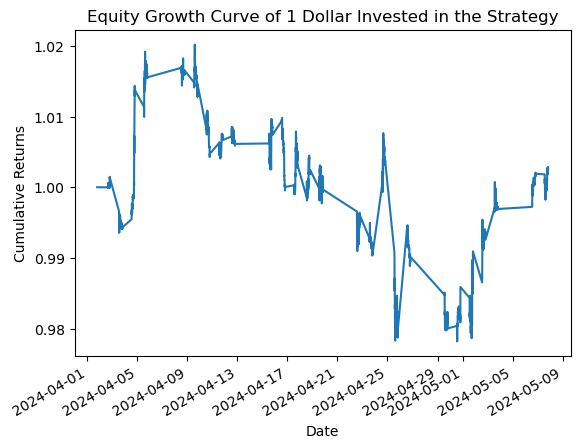

In [10]:
(1+strategy_df["ret"]).cumprod().plot()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title('Equity Growth Curve of 1 Dollar Invested in the Strategy')
plt.show

We can see a lot of volatility in this strategy and the returns are very erratic. The strategy has potential to generate good returns but we can observe that from 9th April to 1st May the strategy returns were in a big downtrend and they kind of recovered towards the end of backtesting period. Seems like we have to figure out what went down between this period.

## Calculating individual stock's KPIs

In [11]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:    
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.066928,-0.489512,0.060992
AAPL,0.519597,1.823438,0.059163
META,-0.862826,-1.552668,0.274142
AMZN,0.134414,0.418088,0.059213
INTC,2.247186,4.358966,0.084296
CSCO,-0.334927,-3.318797,0.054085
VZ,-0.167194,-1.348674,0.047527
IBM,-0.387518,-2.650414,0.101047
TSLA,3.205779,6.711581,0.072481
AMD,-0.253161,-0.777155,0.167075


We can see that the returns are very extreme, ie the positive returns are very good but the negative returns are just as worse.